In [3]:
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from copy import copy
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# Add the 'code' directory to sys.path
project_path = Path(
    '/home/ec2-user/SageMaker/david/tdm-sentiment/'
)
data_path = project_path / 'data/'
data_sample = Path('/home/ec2-user/SageMaker/data/')
dataset_name = 'representative_sample' #TODO representative_sample # 'USATodayDavid' ChicagoTribune' 'Newyork20042023' TheWashingtonPostDavid, LosAngelesTimesDavid, StartupSentiment
folder_path = data_path / 'results/' / dataset_name #TODO

sys.path.append(str(project_path / 'code'))
from salience_index.salience_index import SalienceScorer
# Initialize the scorer
scorer = SalienceScorer()

In [5]:
def get_all_csv_files(folder_path):
    # Use Path to find all CSV files in the folder
    csv_files = list(Path(folder_path).glob('*.csv'))
    return csv_files



def concat_csv_files(folder_path):
    # Get a list of all CSV files in the folder
    csv_files = get_all_csv_files(folder_path)
    
    # Initialize an empty list to store DataFrames
    df_list = []
    
    # Loop through the list of CSV files
    for file in csv_files:
        # Read each CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Append the DataFrame to the list
        df_list.append(df)
    
    # Concatenate all DataFrames in the list into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

    

def label_sentiment(sentiment_score):
    """
    Labels sentiment as 'positive', 'negative', or 'neutral' based on the sentiment score.
    
    Args:
        sentiment_score (float): The sentiment score ranging from -1 to 1.
        
    Returns:
        str: The sentiment label ('positive', 'negative', or 'neutral').
    """
    if sentiment_score > 0.5:
        return 'positive'
    elif sentiment_score < -0.5:
        return 'negative'
    else:
        return 'neutral'
 

# Define a function to compute salience score
def compute_salience(row):
    try:
        return scorer.get_salience_score(row['Date'], row['Page'], row['WordCount'], row['Publisher'])
    except Exception:
        return None


In [42]:
# Combine CSV files from all files
combined_df = concat_csv_files(folder_path)

# Drop duplicate rows based on the 'GOID' column
combined_df = combined_df.drop_duplicates(subset=['GOID'])

# Combine 'International Herald Tribune' and 'New York Times' into one category
combined_df['Publisher'] = combined_df['Publisher'].replace(
    {'international herald tribune': 'new york times',
     'new york times the': 'new york times',
     'international new york times': 'new york times',
     'los angeles times (pre-1997 fulltext)': 'los angeles times',
     'washington post (pre-1997 fulltext) the': 'washington post the',
     }
)


combined_df = combined_df[combined_df['Publisher'] != 'new york times español']


combined_df = combined_df[combined_df[['bert_sentiment', 'Page']].notna().all(axis=1)]
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df = combined_df[combined_df['Date'].dt.year > 2003]
combined_df = combined_df[combined_df['Date'].dt.year < 2024]



# Apply the function to each row
combined_df['salience_score'] = combined_df.apply(compute_salience, axis=1)
combined_df = combined_df[combined_df[['salience_score']].notna().all(axis=1)]
combined_df['adjusted_sentiment'] = combined_df['bert_sentiment']*combined_df['salience_score']


combined_df['normalized_sentiment'] = (
    (combined_df['bert_sentiment'] - combined_df['bert_sentiment'].mean()) / combined_df['bert_sentiment'].std()
)

combined_df['normalized_adjusted_sentiment'] = (
    (combined_df['adjusted_sentiment'] - combined_df['adjusted_sentiment'].mean()) / combined_df['adjusted_sentiment'].std()
)

Normalization failed for page tag: b.6.7.b
Normalization failed for page tag: a.06.7.
Normalization failed for page tag: .
Normalization failed for page tag: .
Normalization failed for page tag: a.1.6.a
Normalization failed for page tag: a.part.
Normalization failed for page tag: 0
Normalization failed for page tag: b.4.5.b
Normalization failed for page tag: .


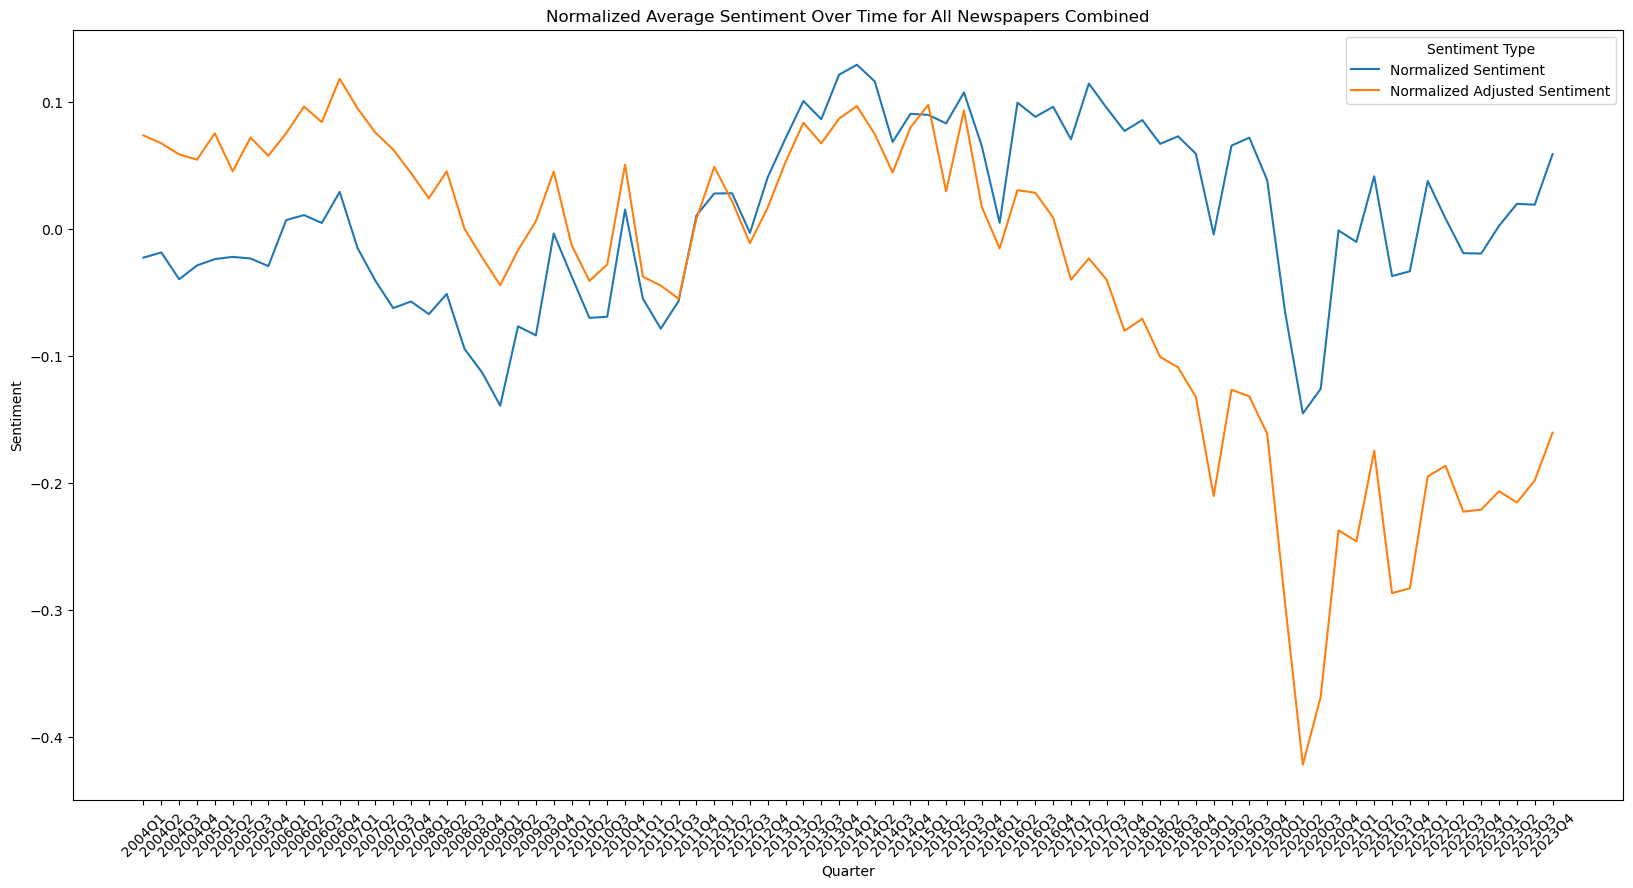

In [46]:
# Prepare the data
df = combined_df.copy()
df['Year'] = pd.to_datetime(df['Date']).dt.year  # Ensure 'Date' is in datetime format
df['Quarter'] = pd.to_datetime(df['Date']).dt.to_period('Q')  # Convert to quarterly periods

# Group by 'Quarter' and calculate the mean sentiment
plot_df = df.groupby('Quarter')[['normalized_sentiment', 'normalized_adjusted_sentiment']].mean().reset_index()

# Convert 'Quarter' back to a string for plotting (if necessary)
plot_df['Quarter'] = plot_df['Quarter'].astype(str)

# Plot the data
plt.figure(figsize=(20, 10))

# Plot two lines for 'normalized_sentiment' and 'normalized_adjusted_sentiment'
sns.lineplot(x='Quarter', y='normalized_sentiment', data=plot_df, label='Normalized Sentiment')
sns.lineplot(x='Quarter', y='normalized_adjusted_sentiment', data=plot_df, label='Normalized Adjusted Sentiment')

# Adjust x-axis ticks for readability
plt.xticks(rotation=45)  # Rotate quarter labels for better display

# Add title and labels
plt.title('Normalized Average Sentiment Over Time for All Newspapers Combined')
plt.xlabel('Quarter')
plt.ylabel('Sentiment')

# Show the plot
plt.legend(title='Sentiment Type')
plt.show()

In [8]:
df = combined_df.copy()
df = df.reset_index()
print(df['Publisher'].unique())
publisher = df['Publisher'][0] #TODO
del df
print(publisher)

publisher = 'all newspapers combined' #TODO

['washington post the' 'chicago tribune' 'los angeles times'
 'new york times' 'usa today']
washington post the


### mean sentiment by quarter

In [15]:
def mean_sentiment_by_quarter(df):
    # Ensure the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Extract year and quarter from the 'Date' column
    df['Year'] = df['Date'].dt.year
    df['Quarter'] = df['Date'].dt.to_period('Q')
    
    # Group by 'Publisher' and 'Quarter' and calculate the mean sentiment for bert and adjusted sentiment
    result = df.groupby(['Quarter', 'Publisher'])[['adjusted_sentiment', 'bert_sentiment']].mean().reset_index()
    
    return result


df = mean_sentiment_by_quarter(combined_df)
#print(quarterly_sentiment['Publisher'].unique())
#df = df[df['Publisher'] == publisher]
df.head()
#print(quarterly_sentiment[quarterly_sentiment['Publisher'] == 'usa today'])

,Quarter,Publisher,adjusted_sentiment,bert_sentiment
0,1995Q1,los angeles times,0.037377,-0.048268
1,1995Q1,washington post the,-0.327719,-0.262853
2,1995Q2,los angeles times,0.109010,0.059729
3,1995Q2,washington post the,-0.194297,-0.150345
4,1995Q3,los angeles times,0.053959,-0.019330


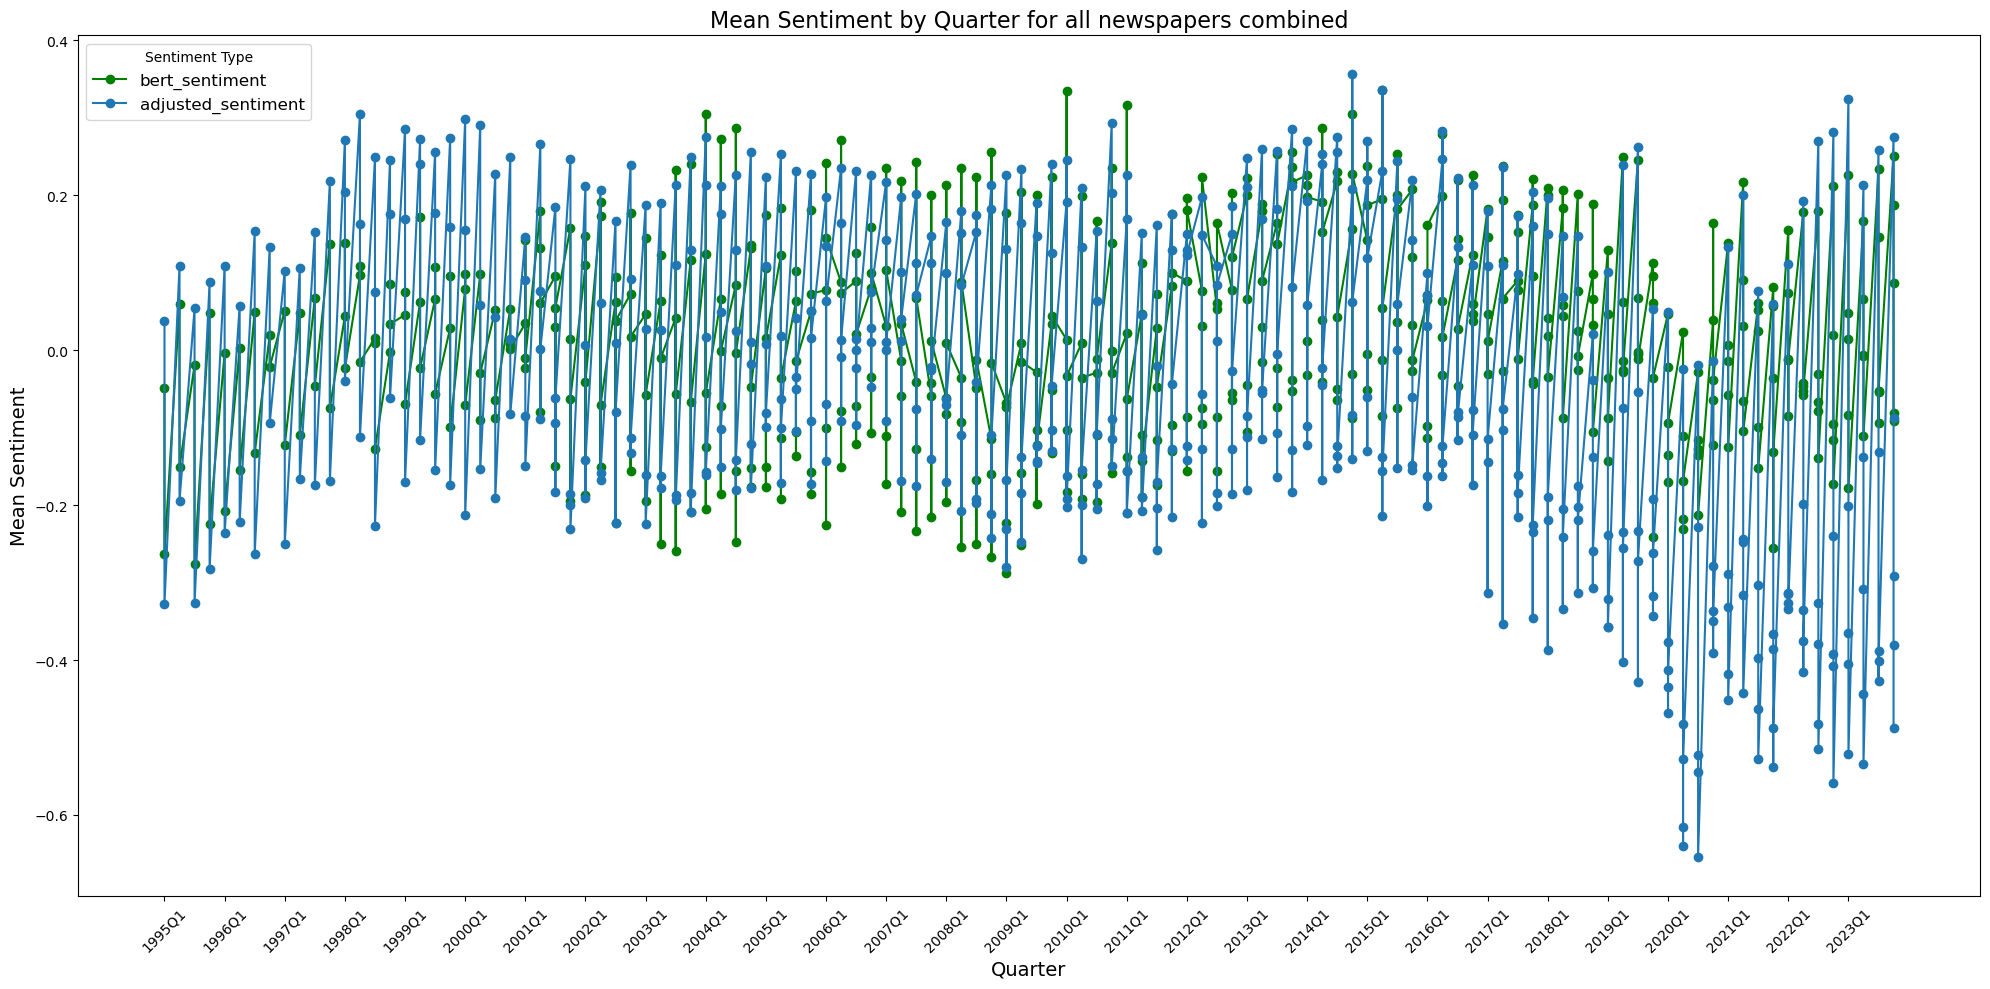

In [16]:
# Ensure the 'Quarter' column is treated as a string
df['Quarter'] = df['Quarter'].astype(str)

# Set the size of the plot
plt.figure(figsize=(20, 10))

# Plot the data using matplotlib
plt.plot(df['Quarter'], df['bert_sentiment'], marker="o", label='bert_sentiment', color='green')
plt.plot(df['Quarter'], df['adjusted_sentiment'], marker="o", label='adjusted_sentiment')

# Customize the plot
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Mean Sentiment', fontsize=14)
plt.title(f'Mean Sentiment by Quarter for {publisher}', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Display only every nth label on the x-axis
plt.gca().set_xticks(plt.gca().get_xticks()[::4])  # Change '4' to a different number if needed

# Add legend
plt.legend(title='Sentiment Type', fontsize=12)

plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()



In [28]:
# Extract year and quarter from the 'Date' column

combined_df['Year'] = combined_df['Date'].dt.year

# Group by 'Publisher' and 'Quarter' and calculate the mean sentiment
result = combined_df.groupby(['Year', 'Publisher'])[['adjusted_sentiment', 'bert_sentiment']].mean().reset_index()
result.head()

,Year,Publisher,adjusted_sentiment,bert_sentiment
0,1995,washington post the,-0.110849,-0.200723
1,1996,washington post the,-0.073315,-0.159103
2,1997,washington post the,-0.045369,-0.101789
3,1998,washington post the,0.013177,-0.021601
4,1999,washington post the,-0.015950,-0.040690


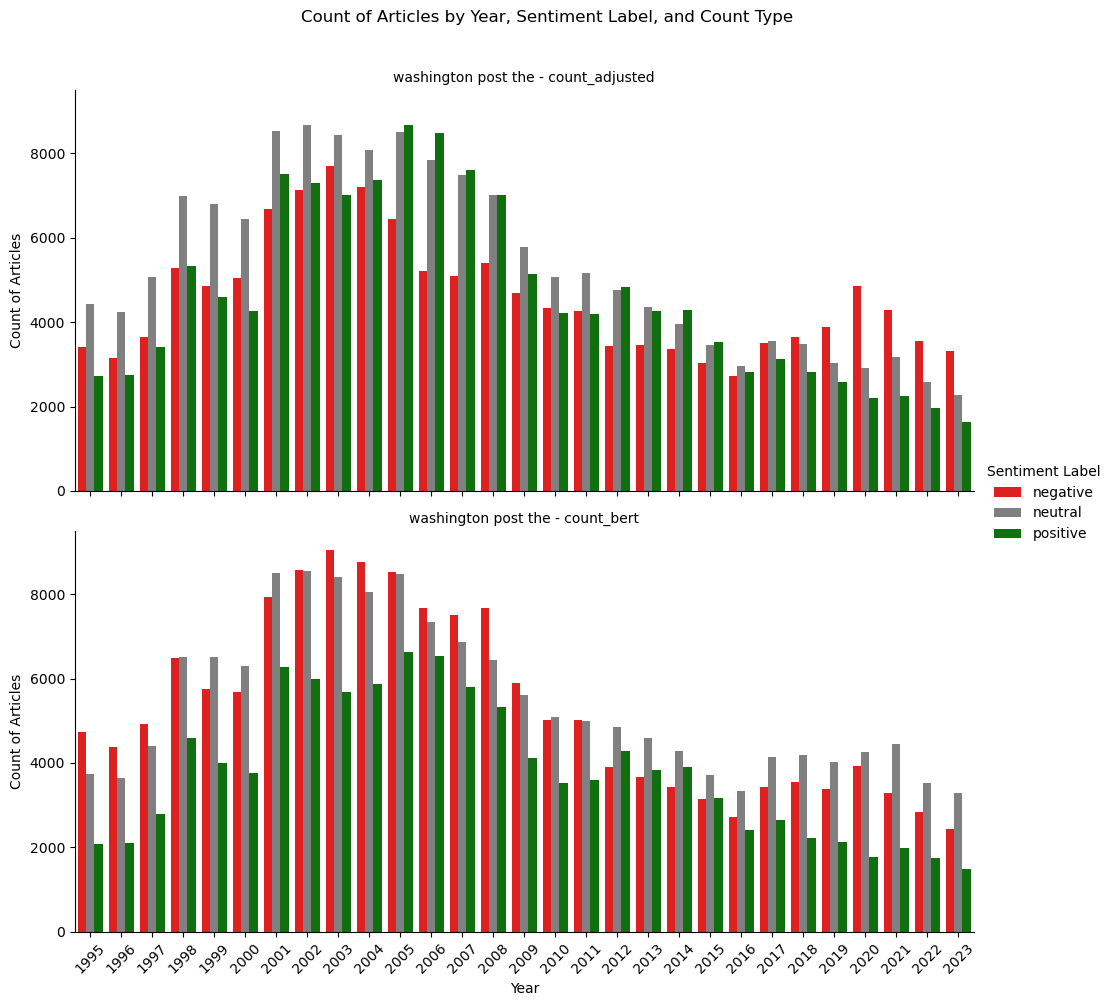

In [29]:
# Group by Publisher, Year, and adjusted_sentiment_label and count occurrences
adjusted_sentiment_label = combined_df.groupby(['Publisher', 'Year', 'adjusted_sentiment_label']).size().reset_index(name='count_adjusted')

# Rename adjusted_sentiment_label column to 'label'
adjusted_sentiment_label = adjusted_sentiment_label.rename(columns={'adjusted_sentiment_label': 'label'})

# Group by Publisher, Year, and bert_sentiment_label and count occurrences
bert_sentiment_label = combined_df.groupby(['Publisher', 'Year', 'bert_sentiment_label']).size().reset_index(name='count_bert')

# Rename bert_sentiment_label column to 'label'
bert_sentiment_label = bert_sentiment_label.rename(columns={'bert_sentiment_label': 'label'})

# Merge the two DataFrames by Publisher, Year, and label
sentiment_counts = pd.merge(adjusted_sentiment_label, bert_sentiment_label, on=['Publisher', 'Year', 'label'], how='outer')

# Reshape the data for plotting both counts and label types
sentiment_counts_melted = pd.melt(
    sentiment_counts,
    id_vars=['Publisher', 'Year', 'label'],
    value_vars=['count_adjusted', 'count_bert'],
    var_name='count_type',
    value_name='Count'
)

# Define a custom color palette for sentiment labels
custom_palette = {'positive': 'green', 'negative': 'red', 'neutral': 'gray'}

# Set up the FacetGrid for each publisher and count type
g = sns.FacetGrid(sentiment_counts_melted, col='Publisher', row='count_type', 
                  height=5, aspect=2, sharey=True)

# Map the data to bar plots within each facet, using 'label' as hue to differentiate sentiment types
g.map_dataframe(sns.barplot, x='Year', y='Count', hue='label', palette=custom_palette)

# Customize the plot
g.add_legend(title='Sentiment Label')  # Add legend for sentiment labels
g.set_axis_labels('Year', 'Count of Articles')  # Set axis labels
g.set_xticklabels(rotation=45, fontsize=10)  # Rotate x-axis labels for readability

# Explicitly ensure all x-axis labels are displayed
for ax in g.axes.flat:
    ax.set_xticks(range(len(sentiment_counts['Year'].unique())))
    ax.set_xticklabels(sentiment_counts['Year'].unique(), rotation=45)

# Use publisher and count type as title for each subplot
g.set_titles('{col_name} - {row_name}')

# Adjust Layout to ensure labels fit
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Count of Articles by Year, Sentiment Label, and Count Type')

# Show the plot
plt.show()


In [49]:
bert_sentiment_label#.head()

,Publisher,Year,label,count_bert
0,new york times,2004,negative,9582
1,new york times,2004,neutral,6521
2,new york times,2004,positive,5272
3,new york times,2005,negative,7897
4,new york times,2005,neutral,6515
...,...,...,...,...
58,new york times,2023,neutral,3199
59,new york times,2023,positive,1378
60,new york times,2024,negative,1093
61,new york times,2024,neutral,2023
